In [ ]:
!pip install opencv-python tensorflow

Mounted at /content/drive
Cataract samples: 594 Normal samples: 500


100%|██████████| 500/500 [05:44<00:00,  1.45it/s]


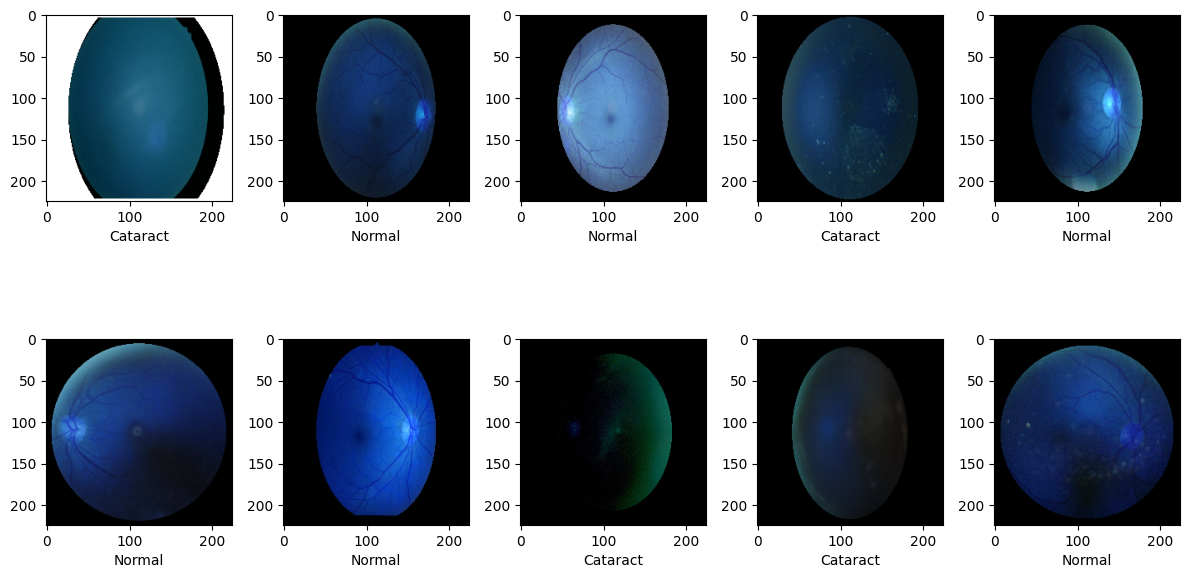

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.6084 - loss: 0.7477
Epoch 1: val_accuracy improved from -inf to 0.90868, saving model to vgg19.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6115 - loss: 0.7421 - val_accuracy: 0.9087 - val_loss: 0.2585 - learning_rate: 0.0010
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.8583 - loss: 0.3469
Epoch 2: val_accuracy did not improve from 0.90868
28/28 ━━━━━━━━━━━━━━━━━━━━ 55s 579ms/step - accuracy: 0.8590 - loss: 0.3456 - val_accuracy: 0.8584 - val_loss: 0.3006 - learning_rate: 0.0010
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.9271 - loss: 0.2508
Epoch 3: val_accuracy improved from 0.90868 to 0.93151, saving model to vgg19.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 557ms/step - accuracy: 0.9267 - loss: 0.2508 - val_accuracy: 0.9315 - val_loss: 0.1919 - learning_rate: 0.0010
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.8817 - loss: 0.2766
Epoch 4: val_accu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix

# =========================
# Load and Label Data
# =========================
file_path = '/content/drive/MyDrive/ODIR-5K/full_df.csv'
df = pd.read_csv(file_path)

def has_cataract(text):
    return 1 if "cataract" in text else 0

df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(has_cataract)
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(has_cataract)

left_cataract = df.loc[(df.C == 1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C == 1) & (df.right_cataract == 1)]["Right-Fundus"].values

left_normal = df.loc[(df.C == 0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250, random_state=42).values
right_normal = df.loc[(df.C == 0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250, random_state=42).values

cataract = np.concatenate((left_cataract, right_cataract), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)
print("Cataract samples:", len(cataract), "Normal samples:", len(normal))

# =========================
# Image Preprocessing
# =========================
dataset_dir = '/content/drive/MyDrive/ODIR-5K/ODIR-5K/Training Images'
image_size = 224
dataset = []

def create_dataset(image_category, label):
    data = []
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
            image = image / 255.0  # Normalization
            data.append([np.array(image), np.array(label)])
        except:
            continue
    return data

dataset += create_dataset(cataract, 1)
dataset += create_dataset(normal, 0)
random.shuffle(dataset)  # 🔁 Moved here to shuffle final dataset properly

# =========================
# Visualize Few Images
# =========================
plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(dataset)
    image = sample[0]
    category = sample[1]
    label = "Cataract" if category == 1 else "Normal"
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()
plt.show()

# =========================
# Prepare Data
# =========================
x = np.array([i[0] for i in dataset])
y = np.array([i[1] for i in dataset])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# =========================
# Model Definition
# =========================
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
for layer in vgg.layers:
    layer.trainable = False

model = Sequential([
    vgg,
    Flatten(),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# =========================
# Callbacks
# =========================
checkpoint = ModelCheckpoint("vgg19.keras", monitor="val_accuracy", verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)  # 🔁 New callback added

# =========================
# Training with Augmentation
# =========================
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(x_train)

history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=30,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    callbacks=[checkpoint, earlystop, reduce_lr])

# =========================
# Evaluation
# =========================
loss, accuracy = model.evaluate(x_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

# =========================
# Confusion Matrix
# =========================
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test, y_pred))


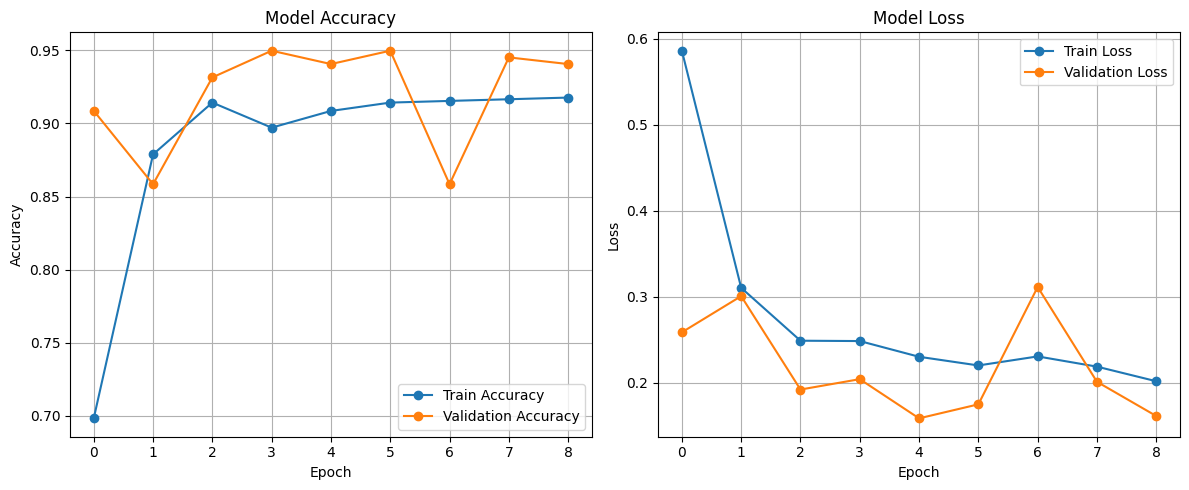

In [ ]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
model.save("eyecat_model.keras")  # Recommended format (newer)
from google.colab import files
files.download("eyecat_model.keras")  # Or .h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>